In [1]:
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image 
from scipy.ndimage import uniform_filter
import numpy as np
from pathlib import Path
#import vcf
import re
import sys
#from tqdm import tqdm
import glob
import shutil


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"

# TWISST: Phylogenetic identification of introgressed genomic regions

In [3]:
Path("{}/results/twisst".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/twisst".format(proj_dir))

## Get VCF file of appropriate snps:

In [18]:
%%bash

conda run -n scan_phylo --cwd . --live-stream \
    vcftools \
        --vcf ../post_phase_filtering/chrs_unrelated.vcf \
        --remove-indv guineensis_saotome_ERR119612 \
        --remove-indv intercalatum_drcongo_ERR119613 \
        --remove-indv matthei_zambia_ERR103051 \
        --mac 1 \
        --recode \
        --recode-INFO-all \
        --stdout \
        >twisst.vcf

In [ ]:
conda run -n bcftools --cwd . --live-stream bgzip -c twisst.vcf > twisst.vcf.gz
conda run -n bcftools --cwd . --live-stream tabix -p vcf twisst.vcf.gz

In [ ]:
conda run -n bcftools --cwd . --live-stream bcftools view twisst.vcf.gz -Ob >twisst.bcf
conda run -n bcftools --cwd . --live-stream bcftools index --threads 12 twisst.bcf

In [ ]:
%%bash

bedtools makewindows -g ../../data/GCF_000699445.3_UoM_Shae.V3_genomic.fna.fai -w 10000 >10kb_windows.bed

In [ ]:
#get counts
bedtools intersect -c -a 10kb_windows.bed -b twisst.vcf.gz >10kb.counts

In [ ]:
#remove those with less than X
awk '{if ($4>50) print $0}' 10kb.counts >inf_10kb.bed

In [ ]:
%%bash

mkdir logs
mkdir gene_vcfs

conda activate bcftools

i=0
while read -r CHROM START STOP COUNT rest; do
    echo $i
    REGION="${CHROM}:${START}-${STOP}"
    OUT_VCF="gene_vcfs/${CHROM}-${START}-${STOP}.vcf"

    bcftools view -r ${REGION} -O v twisst.bcf >${OUT_VCF}
    
    ((i++))
done < inf_10kb.bed

In [ ]:
%%bash 

conda run -n diploid_to_haploid_v"cf --cwd . --live-stream \
    python ~/sch_hae_scan/code/diploid_to_haploid_vcf.py \
        "/master/nplatt/sch_hae_scan/results/twisst/gene_vcfs/*vcf" \
        gene_tree_coords.csv

In [ ]:
%%bash

mkdir gene_phylips
gene_vcfs/*phylip gene_phylips/

rename .vcf.phylip .phy gene_phylips/*.vcf.phylip

In [ ]:
%%bash
mkdir gene_trees
mkdir raxml_logs

In [ ]:
snakemake \
    --printshellcmds \
    --cluster 'qsub -V -cwd -j y -S /bin/bash -pe smp {threads} -q all.q ' \
    --jobs 175 \
    --latency-wait 60 \
    --keep-going \
    --snake ../../code/build_gene_trees.snk.py \
    --use-conda \
    --jobname snk.TWST.{name}.jid{jobid}

In [ ]:
%%bash

cat gene_trees/*raxml.bestTree >gene_trees.nwk

#get coords
ls gene_trees/*raxml.bestTree | sed 's/gene_trees\///' | sed 's/.raxml.bestTree//' | sed 's/-/,/g' >gene_tree_coords.csv

In [ ]:
%%bash
nw_ed gene_trees.nwk 'i & b<=10' o > gene_trees_BS10.nwk

## Run Twisst

In [10]:
!conda run -n bcftools --cwd . --live-stream bcftools query -l twisst.vcf >samples.list

In [40]:
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")

groups  = []
hap_ids = []
with open('samples.list') as ifile:
    for sample in ifile:
        try:
            group=pca_df.loc[pca_df["sample_name"] == sample.rstrip(), "kmeans_label"].values[0]
        except:
            group="outgroup"
            
        groups.append(group)
        groups.append(group)
        
        h1 = "{}_h1".format(sample.rstrip())
        h2 = "{}_h2".format(sample.rstrip())
        
        hap_ids.append(h1)
        hap_ids.append(h2)
        
tmp_df = pd.DataFrame()
tmp_df["hap_ids"] = hap_ids
tmp_df["groups"] = groups
tmp_df.to_csv("groups.list", header=False, index=False, sep="\t")

In [ ]:
 %%bash 
    
python ~/sch_hae_scan/bin/twisst/twisst.py \
    --treeFile gene_trees.nwk \
    --outgroup s_margrebowiei \
    --groupsFile groups.list \
    -g sh_nw \
    -g sb \
    -g sh_se \
    -g s_margrebowiei \
    --outputTopos twisst_topologies \
    -w twisst_weights

## Plot Twisst results

In [4]:
!cat twisst_topologies_BS10

(s_margrebowiei,((sh_nw,sb),sh_se));
(s_margrebowiei,((sh_nw,sh_se),sb));
(s_margrebowiei,(sh_nw,(sb,sh_se)));


In [4]:
#read in topology weights file and convert to percentages
w_df=pd.read_csv("prev/twisst_weights", comment='#', sep="\t")
p_df = w_df.div(w_df.sum(axis=1), axis=0)

In [5]:
w_df

,topo1,topo2,topo3
0,0,1615656,9912
1,1149036,99624,376908
2,865182,309184,451202
3,0,1615656,9912
4,0,1615656,9912
...,...,...,...
37194,49560,1566096,9912
37195,985368,271714,368486
37196,49560,1566096,9912
37197,39648,1576008,9912


In [6]:
p_df

,topo1,topo2,topo3
0,0.000000,0.993902,0.006098
1,0.706852,0.061286,0.231862
2,0.532234,0.190201,0.277566
3,0.000000,0.993902,0.006098
4,0.000000,0.993902,0.006098
...,...,...,...
37194,0.030488,0.963415,0.006098
37195,0.606168,0.167150,0.226681
37196,0.030488,0.963415,0.006098
37197,0.024390,0.969512,0.006098


In [8]:
p_df.mean(axis=0)

topo1    0.085145
topo2    0.875542
topo3    0.039313
dtype: float64

In [6]:
c_df=pd.read_csv("gene_tree_coords.csv", sep=",", header=None)
c_df.columns=["chrom", "start", "stop"]
c_df

,chrom,start,stop
0,NC_067195.1,10000000,10010000
1,NC_067195.1,1000000,1010000
2,NC_067195.1,10000,20000
3,NC_067195.1,10010000,10020000
4,NC_067195.1,10020000,10030000
...,...,...,...
37194,NC_067202.1,9950000,9960000
37195,NC_067202.1,9960000,9970000
37196,NC_067202.1,9970000,9980000
37197,NC_067202.1,9980000,9990000


In [7]:
p_df

,topo1,topo2,topo3
0,0.000000,0.993902,0.006098
1,0.706852,0.061286,0.231862
2,0.532234,0.190201,0.277566
3,0.000000,0.993902,0.006098
4,0.000000,0.993902,0.006098
...,...,...,...
37194,0.030488,0.963415,0.006098
37195,0.606168,0.167150,0.226681
37196,0.030488,0.963415,0.006098
37197,0.024390,0.969512,0.006098


In [8]:
df = pd.concat([p_df, c_df], axis=1)
df

,topo1,topo2,topo3,chrom,start,stop
0,0.000000,0.993902,0.006098,NC_067195.1,10000000,10010000
1,0.706852,0.061286,0.231862,NC_067195.1,1000000,1010000
2,0.532234,0.190201,0.277566,NC_067195.1,10000,20000
3,0.000000,0.993902,0.006098,NC_067195.1,10010000,10020000
4,0.000000,0.993902,0.006098,NC_067195.1,10020000,10030000
...,...,...,...,...,...,...
37194,0.030488,0.963415,0.006098,NC_067202.1,9950000,9960000
37195,0.606168,0.167150,0.226681,NC_067202.1,9960000,9970000
37196,0.030488,0.963415,0.006098,NC_067202.1,9970000,9980000
37197,0.024390,0.969512,0.006098,NC_067202.1,9980000,9990000


In [9]:
#chrom          #len       #x_pos
#chr1   NC_067196.1	93306550	0
#chr2   NC_067197.1	47367863	141634678
#chr3   NC_067198.1	48328128	93306550
#chr4   NC_067199.1	46771736	189002541
#chr5   NC_067200.1	22148653	261283815 
#chr6   NC_067201.1	25509538	235774277
#chr7   NC_067202.1	19481189	283432468
#chrzw  NC_067195.1	89168492	302913657

chr_aliases = { "NC_067195.1": "chrzw",
                "NC_067196.1": "chr1",
                "NC_067197.1": "chr2",
                "NC_067198.1": "chr3",
                "NC_067199.1": "chr4",
                "NC_067200.1": "chr5",
                "NC_067201.1": "chr6",
                "NC_067202.1": "chr7" }

x_chr_pos = { "NC_067196.1":           0 + 10e6 * 0,
              "NC_067197.1":  93_306_550 + 10e6 * 1,
              "NC_067198.1": 141_634_678 + 10e6 * 2, 
              "NC_067199.1": 189_002_541 + 10e6 * 3,
              "NC_067200.1": 235_774_277 + 10e6 * 4,
              "NC_067201.1": 261_283_815 + 10e6 * 5,
              "NC_067202.1": 283_432_468 + 10e6 * 6,
              "NC_067195.1": 302_913_657 + 10e6 * 7}

chr_ticks = [ (          0 +  93_306_550) /2 + 10e6 * 0,
              ( 93_306_550 + 141_634_678) /2 + 10e6 * 1,
              (141_634_678 + 189_002_541) /2 + 10e6 * 2,
              (189_002_541 + 235_774_277) /2 + 10e6 * 3,
              (235_774_277 + 261_283_815) /2 + 10e6 * 4,
              (261_283_815 + 283_432_468) /2 + 10e6 * 5,
              (283_432_468 + 302_913_657) /2 + 10e6 * 6,
              (302_913_657 + 392_082_149) /2 + 10e6 * 7 ]

#chr_labels=list(x_chr_pos.keys())
chr_labels=[ "Chr1", "Chr2", "Chr3", "Chr4", "Chr5", "Chr6", "Chr7", "ChrZW"]

x_starts = []
x_ends = []
for index, row in df.iterrows():
    chrom = row["chrom"]
    start = row["start"]
    end   = row["stop"]
    x_start = start + x_chr_pos[chrom]
    x_end   = end + x_chr_pos[chrom]
    
    x_starts.append(x_start)
    x_ends.append(x_end)
    
df["x_start"] = x_starts
df["x_end"]  = x_ends

df.sort_values(by=["x_start"], inplace=True)
df.reset_index(inplace=True, drop=True)
df

,topo1,topo2,topo3,chrom,start,stop,x_start,x_end
0,0.332619,0.321227,0.346154,NC_067196.1,140000,150000,140000.0,150000.0
1,0.440908,0.245261,0.313831,NC_067196.1,150000,160000,150000.0,160000.0
2,0.173354,0.347872,0.478774,NC_067196.1,170000,180000,170000.0,180000.0
3,0.230086,0.344603,0.425311,NC_067196.1,190000,200000,190000.0,200000.0
4,0.044135,0.345819,0.610046,NC_067196.1,200000,210000,200000.0,210000.0
...,...,...,...,...,...,...,...,...
37194,0.034983,0.944381,0.020635,NC_067195.1,89100000,89110000,462013657.0,462023657.0
37195,0.286237,0.567856,0.145907,NC_067195.1,89110000,89120000,462023657.0,462033657.0
37196,0.035714,0.963415,0.000871,NC_067195.1,89120000,89130000,462033657.0,462043657.0
37197,0.044543,0.737650,0.217807,NC_067195.1,89130000,89140000,462043657.0,462053657.0


In [13]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x_start=[]
x_end=[]
c=[]

for index, row in df.iterrows():
    chrom = row["chrom"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x_start.append(row["start"] + offset)
    x_end.append(row["stop"] + offset)

    c.append(color)
    
df["x_start"] = x_start
df["x_end"] = x_end
df["color"] = c

df.to_csv("twisst_results.csv", header=True, sep=",", index=False)
df

,topo1,topo2,topo3,chrom,start,stop,x_start,x_end,color
0,0.332619,0.321227,0.346154,NC_067196.1,140000,150000,140000,150000,#078d70
1,0.440908,0.245261,0.313831,NC_067196.1,150000,160000,150000,160000,#078d70
2,0.173354,0.347872,0.478774,NC_067196.1,170000,180000,170000,180000,#078d70
3,0.230086,0.344603,0.425311,NC_067196.1,190000,200000,190000,200000,#078d70
4,0.044135,0.345819,0.610046,NC_067196.1,200000,210000,200000,210000,#078d70
...,...,...,...,...,...,...,...,...,...
37194,0.034983,0.944381,0.020635,NC_067195.1,89100000,89110000,409513657,409523657,#7bade3
37195,0.286237,0.567856,0.145907,NC_067195.1,89110000,89120000,409523657,409533657,#7bade3
37196,0.035714,0.963415,0.000871,NC_067195.1,89120000,89130000,409533657,409543657,#7bade3
37197,0.044543,0.737650,0.217807,NC_067195.1,89130000,89140000,409543657,409553657,#7bade3


In [ ]:
df = pd.read_csv("twisst_results.csv", sep=",")


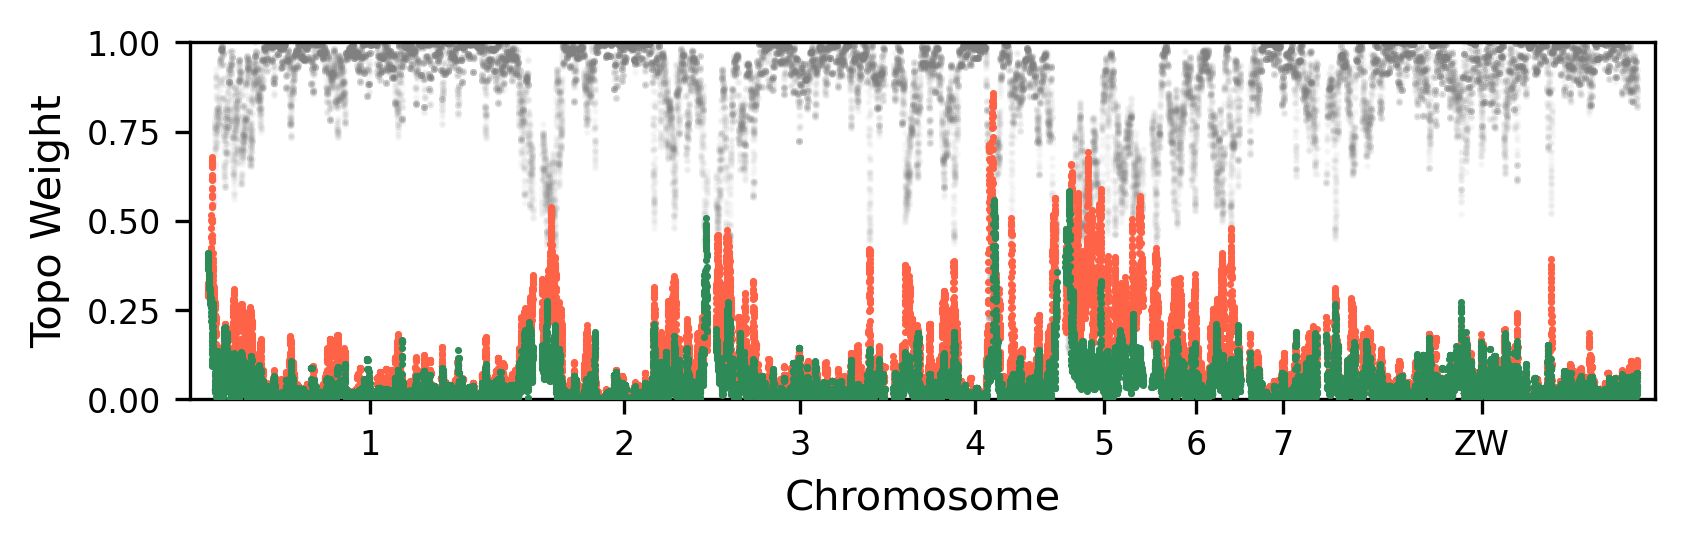

In [121]:
cm = 1/2.54
figure(figsize=(16*cm, 4*cm), facecolor="white", dpi=300)

k=21

t1=df['topo1']
t2=df['topo2']
t3=df['topo3']

m1=medfilt(t1, kernel_size=k)
m2=medfilt(t2, kernel_size=k)
m3=medfilt(t3, kernel_size=k)

u1=uniform_filter(t1, size=k)
u2=uniform_filter(t2, size=k)
u3=uniform_filter(t3, size=k)

x=df['x_start']

plt.scatter(x, u3, label='(Sb,SE)', s=0.5, c="seagreen", zorder=3, alpha=1)
plt.scatter(x, u1, label='(Sb,NW)', s=0.5, c="tomato", zorder=2, alpha=1)
plt.scatter(x, u2, label='(NW,SE)', s=0.5, c="grey", zorder=1, alpha=0.05)

invad_loc= offsets["NC_067199.1"] + (28_467_137 + 28_467_137)/2
#plt.axvline(invad_loc_start, color='black', linewidth=1, zorder=1, alpha=0.2)  # This will draw a vertical dashed red line at invad_loc_start

plt.xlabel("Chromosome")
plt.ylabel("Topo Weight")
#plt.legend(title="Topologies", loc='upper right')
plt.xticks(x_ticks, ["1", "2", "3", "4", "5", "6", "7", "ZW"], fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([x.min()-5_000_000, x.max()+5_000_000])
plt.ylim([0,1])
plt.savefig("twisst_comparison.png")
plt.show()


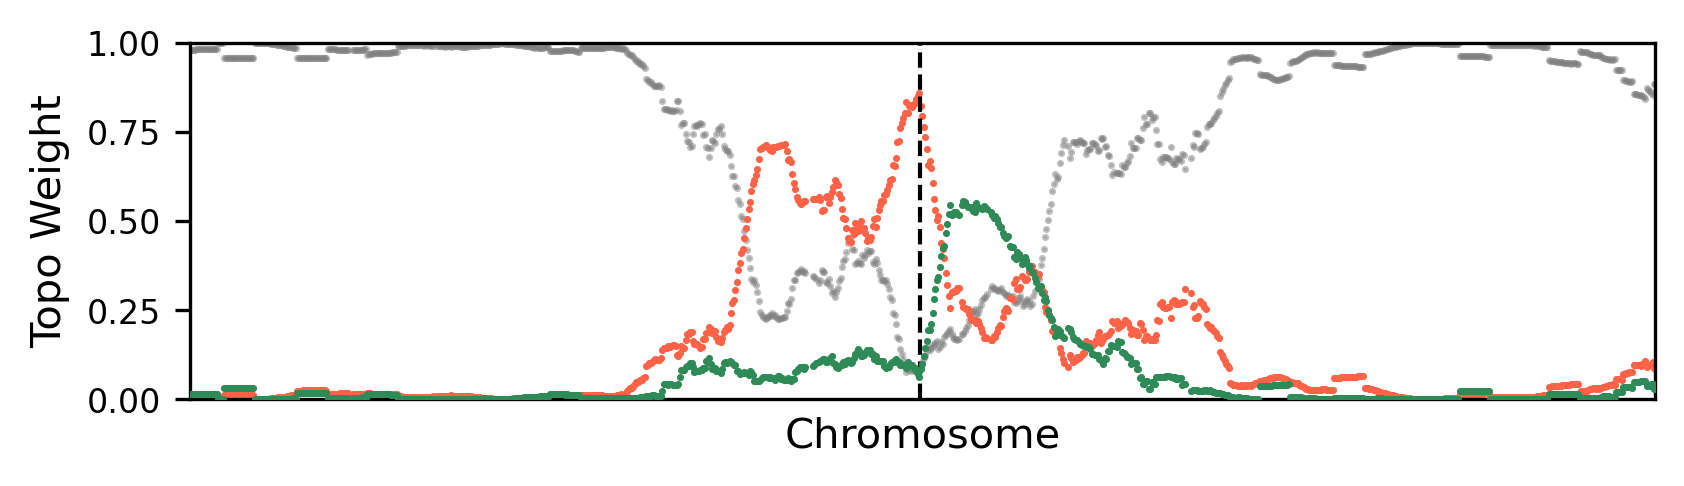

In [128]:
cm = 1/2.54
figure(figsize=(16*cm, 4*cm), facecolor="white", dpi=300)

k=21

t1=df['topo1']
t2=df['topo2']
t3=df['topo3']

m1=medfilt(t1, kernel_size=k)
m2=medfilt(t2, kernel_size=k)
m3=medfilt(t3, kernel_size=k)

u1=uniform_filter(t1, size=k)
u2=uniform_filter(t2, size=k)
u3=uniform_filter(t3, size=k)

x=df['x_start']

plt.scatter(x, u3, label='(Sb,SE)', s=0.5, c="seagreen", zorder=3, alpha=1)
plt.scatter(x, u1, label='(Sb,NW)', s=0.5, c="tomato", zorder=2, alpha=1)
plt.scatter(x, u2, label='(NW,SE)', s=0.5, c="grey", zorder=1, alpha=0.5)

invad_loc= offsets["NC_067199.1"] + (28_467_137 + 28_467_137)/2
#plt.axvline(invad_loc_start, color='black', linewidth=1, zorder=1, alpha=0.2)  # This will draw a vertical dashed red line at invad_loc_start

plt.xlabel("Chromosome")
plt.ylabel("Topo Weight")
#plt.legend(title="Topologies", loc='upper right')
plt.xticks(x_ticks, ["1", "2", "3", "4", "5", "6", "7", "ZW"], fontsize=8)
plt.yticks(fontsize=8)
x_min=offsets["NC_067199.1"] + (28_467_137) - 5000000
x_max=offsets["NC_067199.1"] + (28_495_140) + 5000000
plt.xlim([x_min, x_max])

invad_loc= offsets["NC_067199.1"] + (28_467_137 + 28_467_137)/2
plt.axvline(invad_loc_start, color='black', linestyle='--', linewidth=1)  # This will draw a vertical dashed red line at invad_loc_start
#plt.axvline(invad_loc_stop, color='black', linestyle='--', linewidth=1)   # This will draw a vertical dashed red


plt.ylim([0,1])
plt.savefig("twisst_comparison_invad_loc.png")
plt.show()


In [45]:
# Function to apply uniform filter
def apply_uniform_filter(group):
    size = 21  # You can adjust the filter size as required
    group['s_topo1'] = uniform_filter(group['topo1'], size=size)
    group['s_topo2'] = uniform_filter(group['topo2'], size=size)
    group['s_topo3'] = uniform_filter(group['topo3'], size=size)
    return group

# Group by 'chrom' and apply the filter
df = df.groupby('chrom').apply(apply_uniform_filter)

In [ ]:
offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
offsets

KeyboardInterrupt: 

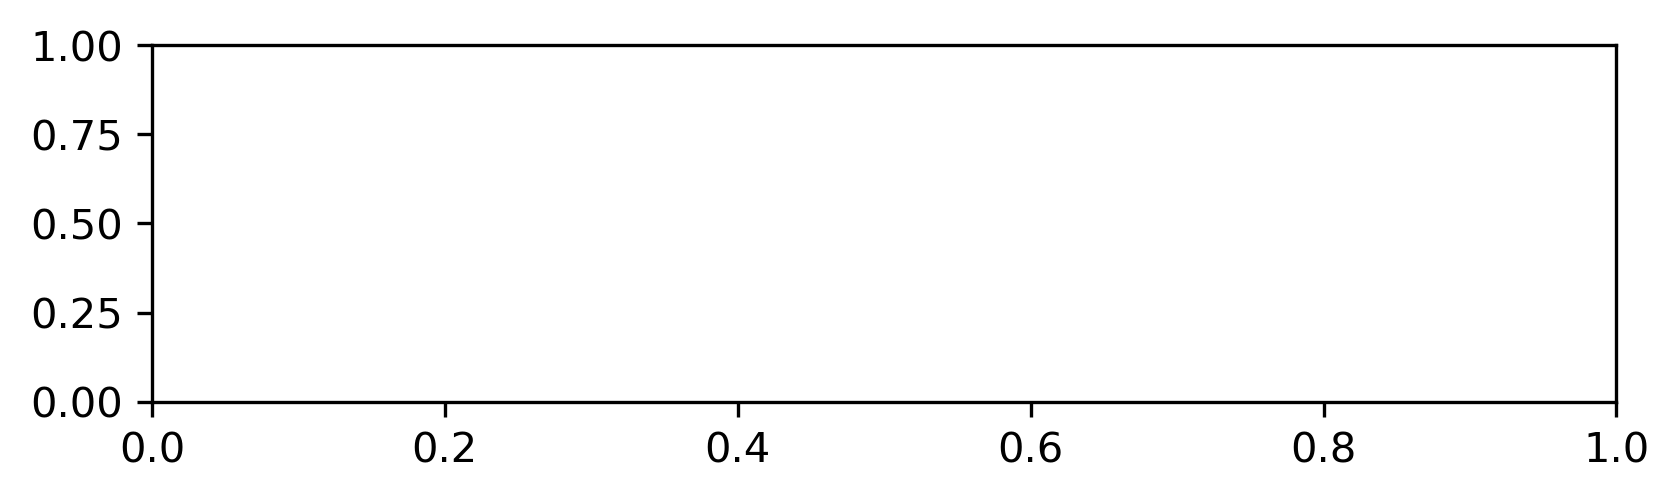

In [105]:
cm = 1/2.54
figure(figsize=(16*cm, 4*cm), facecolor="white", dpi=300)

pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",")  #generated in prep_figs_info.ipynb

t1=df['s_topo1']
t2=df['s_topo2']
t3=df['s_topo3']

w=df["x_end"] - df["x_start"]
x=df['x_start']

plt.bar(x, t1, w,                 label="(NW,Sb),SE",  color="#078d70")
plt.bar(x, t2, w, bottom=t1,      label="(NW,SE),Sb",  color="#7bade3")
plt.bar(x, t3, w, bottom=t1 + t2, label="(Sb,SE),NW",  color="#3e1a78")

x_ticks =list(pos_df["mid_tick"].astype(int)[0:8])
x_labels =list(pos_df["contig"].astype(str)[0:8])

plt.xlabel("Chromosome")
plt.ylabel("Topo Weight")
plt.legend(title="Topologies", loc='upper right')
plt.xticks(x_ticks, x_labels, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([x.min()-5_000_000, x.max()+5_000_000])
plt.ylim([0,1])

#ax.legend()
invad_loc= offsets["NC_067199.1"] + (28_467_137 + 28_467_137)/2
plt.axvline(invad_loc_start, color='red', linestyle='--', linewidth=1)  # This will draw a vertical dashed red line at invad_loc_start
plt.axvline(invad_loc_stop, color='red', linestyle='--', linewidth=1)   # This will draw a vertical dashed red



x_min=offsets["NC_067199.1"] + (28_467_137) - 5000000
x_max=offsets["NC_067199.1"] + (28_495_140) + 5000000
plt.xlim([x_min, x_max])
#plt.ylim(0,1)

plt.savefig(f"test_twisst.png")
#plt.close()
plt.show()

#Image("test_twisst.png")

In [91]:
cm = 1/2.54
figure(figsize=(16*cm, 4*cm), facecolor="white", dpi=300)

pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",")  #generated in prep_figs_info.ipynb

t1=df['topo1']
t2=df['topo2']
t3=df['topo3']

w=df["x_end"] - df["x_start"]
x=df['x_start']

plt.bar(x, t1, w,                 label="(NW,Sb),SE",  color="#078d70")
plt.bar(x, t2, w, bottom=t1,      label="(NW,SE),Sb",  color="#7bade3")
plt.bar(x, t3, w, bottom=t1 + t2, label="(Sb,SE),NW",  color="#3e1a78")

x_ticks =list(pos_df["mid_tick"].astype(int)[0:8])
x_labels =list(pos_df["contig"].astype(str)[0:8])

plt.xlabel("Chromosome")
plt.ylabel("Topo Weight")
plt.legend(title="Topologies", loc='upper right')
plt.xticks(x_ticks, x_labels, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([x.min()-5_000_000, x.max()+5_000_000])
plt.ylim([0,1])

#ax.legend()
invad_loc_start = offsets["NC_067199.1"] + (28_467_137)
invad_loc_stop = offsets["NC_067199.1"] + (28_495_140)


plt.axvline(invad_loc_start, color='red', linestyle='--', linewidth=1)  # This will draw a vertical dashed red line at invad_loc_start
plt.axvline(invad_loc_stop, color='red', linestyle='--', linewidth=1)   # This will draw a vertical dashed red



x_min=offsets["NC_067199.1"] + (28_467_137) - 5000000
x_max=offsets["NC_067199.1"] + (28_495_140) + 5000000
plt.xlim([x_min, x_max])
#plt.ylim(0,1)

#plt.savefig(f"test_twisst.png")
#plt.close()
plt.show()

#Image("test_twisst.png")

KeyboardInterrupt: 

In [84]:
import vcf

ModuleNotFoundError: No module named 'vcf'

In [83]:
import vcf

input_vcf_path = "test.vcf"
output_vcf_path = "haploid.vcf"

# Open the input VCF
vcf_reader = vcf.Reader(open(input_vcf_path, 'r'))

# Update the samples list to create pseudo haploid samples
vcf_reader.samples = [sample + '_0' for sample in vcf_reader.samples] + [sample + '_1' for sample in vcf_reader.samples]

# Open the output VCF for writing
vcf_writer = vcf.Writer(open(output_vcf_path, 'w'), vcf_reader)

for record in vcf_reader:
    # Separate each sample's genotype into two alleles
    haploid_samples = []
    for sample in record.samples:
        # First allele
        haploid_0 = vcf.model._Call(record, sample.sample + '_0', [sample.gt_alleles[0], sample.gt_alleles[0]])
        # Second allele
        haploid_1 = vcf.model._Call(record, sample.sample + '_1', [sample.gt_alleles[1], sample.gt_alleles[1]])
        haploid_samples.extend([haploid_0, haploid_1])
    record.samples = haploid_samples
    vcf_writer.write_record(record)

vcf_writer.close()


ModuleNotFoundError: No module named 'vcf'

In [47]:
topos = {
    "topo1": "(NW,Sb),SE",
    "topo2": "(NW,SE),Sb",
    "topo3": "NW,(Sb,SE)" }

for x in ["topo1", "topo2", "topo3"]:
    print(f"mean topo weight for {x} is {str(df[x].mean())} {topos[x]}")

# df["topo1"].mean()

mean topo weight for topo1 is 0.08514541833027346 (NW,Sb),SE
mean topo weight for topo2 is 0.8755419749162067 (NW,SE),Sb
mean topo weight for topo3 is 0.03931260675351985 NW,(Sb,SE)


In [37]:
w=df["x_end"] - df["x_start"]
w

0        10000
1        10000
2        10000
3        10000
4        10000
         ...  
37194    10000
37195    10000
37196    10000
37197    10000
37198    10000
Length: 37199, dtype: int64

In [14]:
#plot weights
figure(figsize=(12, 3), dpi=300)

kernel_size=21

w=df["x_end"] - df["x_start"]
x=df["x_start"]

t1 = uniform_filter(df["topo1"], size=kernel_size)
t2 = uniform_filter(df["topo2"], size=kernel_size)
t3 = uniform_filter(df["topo3"], size=kernel_size)

plt.bar(x, t1, w,                 label="(sh_nw,sb),sh_se)", color="red")
plt.bar(x, t3, w, bottom=t1,      label="(sh_nw,(sb,sh_se)", color="blue")
plt.bar(x, t2, w, bottom=t1 + t3, label="((sh_nw,sh_se),sb)", color="silver")

plt.xlabel("Chromosome")
plt.ylabel("Topo Weight")
plt.legend(title="Topologies", loc='upper right')
plt.xticks(chr_ticks, chr_labels, fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([x.min()-5_000_000, x.max()+5_000_000])
plt.ylim([0,1])

plt.savefig(f"twisst_k{kernel_size}.png", dpi=300)
plt.close()

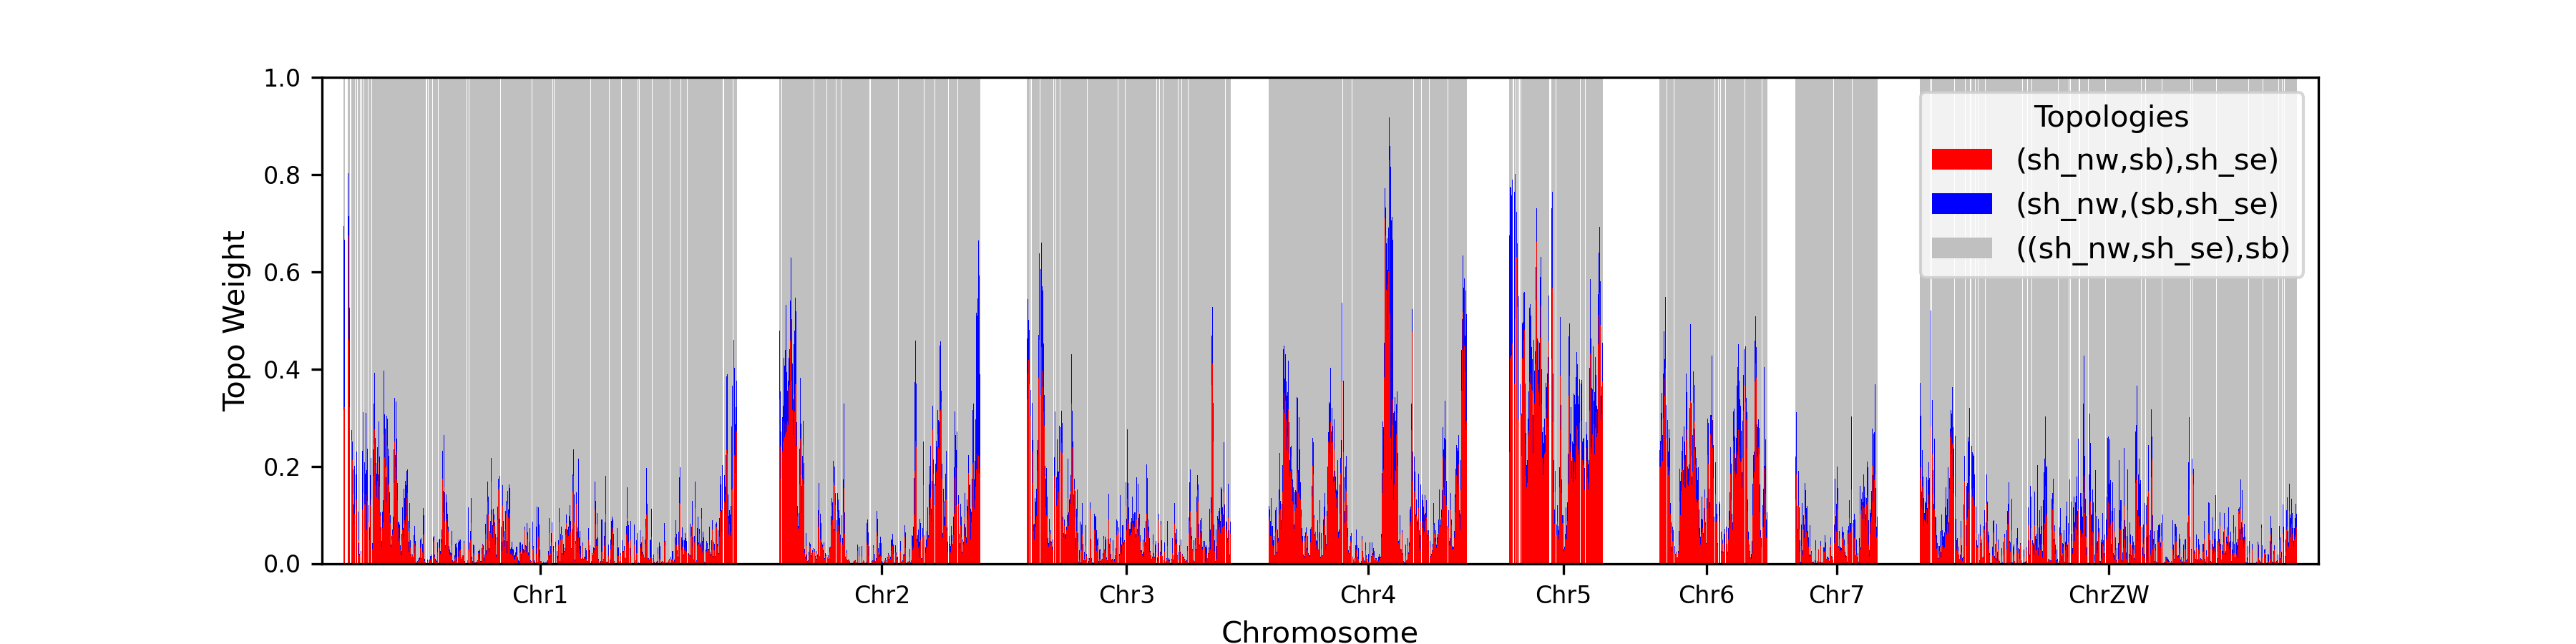

In [15]:
Image("twisst_k21.png")

### Get basic data on the size of windows used for gene trees

In [75]:
(c_df["stop"] - c_df["start"]).mean()

9999.528697007983

In [76]:
(c_df["stop"] - c_df["start"]).median()

10000.0

In [77]:
(c_df["stop"] - c_df["start"]).max()

10000

In [78]:
(c_df["stop"] - c_df["start"]).min()

1736

(0.0, 100000.0)

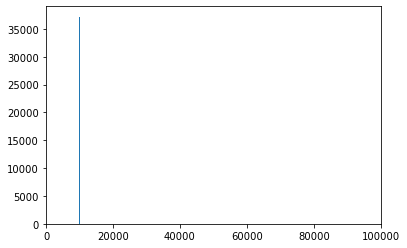

In [79]:
plt.hist((c_df["stop"] - c_df["start"]), bins=300)
plt.xlim([0, 100_000])

# SVDquartets: Species Tree

In [5]:
Path("{}/results/svdq".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/svdq".format(proj_dir))

In [14]:
%%bash

vcftools \
    --vcf ../post_phase_filtering/autosomes_unrelated.vcf \
    --remove-indv guineensis_saotome_ERR119612 \
    --remove-indv intercalatum_drcongo_ERR119613 \
    --remove-indv matthei_zambia_ERR103051 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >sb_sh_sm.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/autosomes_unrelated.vcf
	--recode-INFO-all
	--recode
	--stdout
	--remove-indv guineensis_saotome_ERR119612
	--remove-indv intercalatum_drcongo_ERR119613
	--remove-indv matthei_zambia_ERR103051

Excluding individuals in 'exclude' list
After filtering, kept 163 out of 166 Individuals
Outputting VCF file...
After filtering, kept 28590241 out of a possible 28590241 Sites
Run Time = 2021.00 seconds


In [232]:
!vcftools --singletons --vcf sb_sh_sm.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/autosomes_unrelated.vcf
	--singletons

After filtering, kept 166 out of 166 Individuals
Outputting Singleton Locations
After filtering, kept 28590241 out of a possible 28590241 Sites
Run Time = 647.00 seconds


In [31]:
%%bash

sed 1d out.singletons | cut -f1,2 >singleton_positions.list
wc -l singleton_positions.list

7942341 singleton_positions.list


In [32]:
%%bash

vcftools \
    --exclude-positions singleton_positions.list \
    --vcf sb_sh_sm.vcf \
    --recode \
    --recode-INFO-all \
    --stdout \
    >svdq.vcf


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf sb_sh_sm.vcf
	--exclude-positions singleton_positions.list
	--recode-INFO-all
	--recode
	--stdout

After filtering, kept 163 out of 163 Individuals
Outputting VCF file...
After filtering, kept 20647900 out of a possible 28590241 Sites
Run Time = 1531.00 seconds


In [33]:
#convert to nexus
!~/sch_hae_scan/bin/vcf2phylip/vcf2phylip.py -i svdq.vcf -r -n -p


Converting file 'svdq.vcf':

Number of samples in VCF: 163
500000 genotypes processed.
1000000 genotypes processed.
1500000 genotypes processed.
2000000 genotypes processed.
2500000 genotypes processed.
3000000 genotypes processed.
3500000 genotypes processed.
4000000 genotypes processed.
4500000 genotypes processed.
5000000 genotypes processed.
5500000 genotypes processed.
6000000 genotypes processed.
6500000 genotypes processed.
7000000 genotypes processed.
7500000 genotypes processed.
8000000 genotypes processed.
8500000 genotypes processed.
9000000 genotypes processed.
9500000 genotypes processed.
10000000 genotypes processed.
10500000 genotypes processed.
11000000 genotypes processed.
11500000 genotypes processed.
12000000 genotypes processed.
12500000 genotypes processed.
13000000 genotypes processed.
13500000 genotypes processed.
14000000 genotypes processed.
14500000 genotypes processed.
15000000 genotypes processed.
15500000 genotypes processed.
16000000 genotypes processed.


In [67]:
!conda run -n bcftools --cwd . --live-stream bcftools query -l svdq.vcf >samples.list

In [68]:
!cp svdq.min4.nexus svdq.nexus

In [7]:
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")

In [8]:
# Read in samples.list
with open("samples.list", "r") as f:
    samples = [line.strip() for line in f]

# Create a defaultdict with lists as default values
sample_dict = defaultdict(list)

# Iterate through the samples
for sample in samples:
    # Look up the "pca_species" and "country" in pca_df for the current sample
    pca_species, country = pca_df.loc[pca_df['sample_name'] == sample, ['pca_species', 'country']].values[0]

    # Create the dictionary key
    key = f"{pca_species}.{country}".replace("_", ".")

    # Append the sample to the list in the dictionary
    sample_dict[key].append(sample)

In [9]:
#write the nexus block    
with open("tax_partition.nex", 'w') as f:
    
    f.write("#NEXUS\n")
    f.write("begin sets;\n")
    f.write("taxpartition populations = \n")    
    for pop in sample_dict:
        pop_samples = " ".join(sample_dict[pop])
        #pop_samples = " ".join([item + suffix for item in sample_dict[pop] for suffix in ('_h1', '_h2')])
        f.write(f"\t{pop}:\t\t{pop_samples},\n")
    f.write("\t;\n")
    f.write("end;\n")

In [10]:
%%bash 

echo """

begin paup;
    
    log start file=svdq_pops.log replace;

    svdq evalQuartets=random
         nquartets=2500000
         taxpartition=populations
         nthreads=192
         bootstrap=standard
         nreps=100
         treeFile=svdq_pops_boottrees.nex
         seed=12345
         replace=yes
         ;

    savetrees
        file=svdq_pops_constree.nex
        supportValues=Both
        maxDecimals=2
        ;
end;

""" >svdq_pops_block.nexus

In [ ]:
~/sch_hae_scan/bin/paup4a168_ubuntu64

In [ ]:
execute svdq.nexus

In [ ]:
execute tax_partition.nex

In [ ]:
execute svdq_pops_block.nexus

In [ ]:
# Analysis using SVDQuartets method
#                                                                                                                                                                                                                                                Number of taxa (lineages) in the analysis = 163                                                                                                                                                                                              Tips assigned to species using taxon partition 'populations'                                                                                                                                                                                 Quartet sampling = random (seed = 12345)                                                                                                                                                                                                     Number of random quartets sampled = 2500000                                                                                                                                                                                                    This number equals the number of taxa raised to the power of 2.892,                                                                                                                                                                          and represents 16.92% of the total number of distinct quartets                                                                                                                                                                             Doing standard bootstrap analysis                                                                                                                                                                                                              Initial bootstrap seed comes from same sequence as random quartet sampling                                                                                                                                                                   Number of bootstrap replicates = 100                                                                                                                                                                                                       Tree model = multispecies coalescent (expected rank of flattening matrix for true tree = 10)                                                                                                                                                 Using 192 parallel threads on 96 physical (192 logical) processors
#   Tree search:                                                                                                                                                                                                                                   Quartet assembly algorithm = QFM
#     Local search = none                                                                                                                                                                                                                        Writing trees for bootstrap replicates to file: svdq_pops_boottrees.nex                                                                                                                                                                                                                                                                                                                                                                                                                 Getting SVD scores for random quartets...                                                                                                                                                                                                    [##################################################] 100.0%                                                                                                                                                                                  
# Assembling quartets...                                                                                                                                                                                                                       [##################################################] 100.0%
#                                                                                                                                                                                                                                              Quartet assembly completed:                                                                                                                                                                                                                    Total weight of incompatible quartets = 387749 (15.510%)                                                                                                                                                                                     Total weight of compatible quartets   = 2112251 (84.490%)
#   Time used for QFM = 0.82 sec (CPU time = 00:01:53.7)

In [ ]:
#restart paup

In [ ]:
~/sch_hae_scan/bin/paup4a168_ubuntu64

In [ ]:
log start file=svdq_indv.log replace;

In [ ]:
execute svdq.nexus

In [ ]:
svdq evalQuartets=random nquartets=2500000 bootstrap=standard nreps=100 nthreads=192 treeFile=svdq_indv_boottrees.nex seed=12345 replace=yes

In [ ]:
savetrees file=svdq_indv_constree.nex supportValues=Both maxDecimals=2

In [ ]:
# Number of taxa (lineages) in the analysis = 163
# No species-membership partition is in effect; assuming one tip per species
# Quartet sampling = random (seed = 12345)
# Number of random quartets sampled = 2500000
#     This number equals the number of taxa raised to the power of 2.892,
#     and represents 8.821% of the total number of distinct quartets
# Doing standard bootstrap analysis
#     Initial bootstrap seed comes from same sequence as random quartet sampling
#     Number of bootstrap replicates = 100
# Tree model = multispecies coalescent (expected rank of flattening matrix for true tree = 10)
# Using 192 parallel threads on 96 physical (192 logical) processors
# Tree search:
#     Quartet assembly algorithm = QFM
#     Local search = none
# Writing trees for bootstrap replicates to file: svdq_indv_boottrees.nex

# Getting SVD scores for random quartets...
# [##################################################] 100.0%

# Assembling quartets...
# [##################################################] 100.0%
# Quartet assembly completed:
#     Total weight of incompatible quartets = 463571 (18.543%)
#     Total weight of compatible quartets   = 2036429 (81.457%)
#     Time used for QFM = 8.56 sec (CPU time = 00:25:39.8)

In [ ]:
# begin trees;
# translate
# 1 one,
# 2 two,
# 3 three,
# 4 four;

In [222]:
# Create a defaultdict with lists as default values
countries = {}
species = {}

# Iterate through the samples
for sample in samples:
    # Look up the "pca_species" and "country" in pca_df for the current sample
    species[sample], countries[sample] = pca_df.loc[pca_df['sample_name'] == sample, ['pca_species', 'country']].values[0]

In [221]:
species

's_bovis'

In [225]:
with open("translate.nex", 'w') as f:
    
    f.write("#NEXUS\n")
    f.write("begin trees;\n")
    f.write("\ttranslate\n")    
    for original_sample_name in samples:
        sp=species[original_sample_name]
        country=countries[original_sample_name]
        new_sample_name=f"{sp}-{country}-{original_sample_name}"
        f.write(f"\t\t{original_sample_name}\t\t{new_sample_name},\n")
    f.write("\t;\n")
    f.write("end;\n")

In [226]:
!cat translate.nex

#NEXUS
begin trees;
	translate
		Sb_NG_au_1.2		s_bovis-nigeria-Sb_NG_au_1.2,
		Sb_NG_au_2.10		s_bovis-nigeria-Sb_NG_au_2.10,
		Sb_NG_au_2.13		s_bovis-nigeria-Sb_NG_au_2.13,
		Sb_NG_au_2.5		s_bovis-nigeria-Sb_NG_au_2.5,
		Sb_NG_au_2.6		s_bovis-nigeria-Sb_NG_au_2.6,
		Sb_NG_be_1.10		s_bovis-nigeria-Sb_NG_be_1.10,
		Sb_NG_be_1.3		s_bovis-nigeria-Sb_NG_be_1.3,
		Sb_NG_be_1.5		s_bovis-nigeria-Sb_NG_be_1.5,
		Sb_NG_en_1.1		s_bovis-nigeria-Sb_NG_en_1.1,
		Sh_NG_eb_6_2		s_haematobium-nigeria-Sh_NG_eb_6_2,
		Sh_NG_ed_1_3		s_haematobium-nigeria-Sh_NG_ed_1_3,
		Sh_NG_ed_3_2		s_haematobium-nigeria-Sh_NG_ed_3_2,
		Sh_NG_kb_2_1		s_haematobium-nigeria-Sh_NG_kb_2_1,
		Sh_NG_kw_1_10		s_haematobium-nigeria-Sh_NG_kw_1_10,
		Sh_NG_os_1_4		s_haematobium-nigeria-Sh_NG_os_1_4,
		bovis_ethiopia_SRR13579874		s_bovis-ethiopia-bovis_ethiopia_SRR13579874,
		bovis_keyna_SRR13579878		s_bovis-kenya-bovis_keyna_SRR13579878,
		bovis_senegal_SRR13579876		s_bovis-senegal-bovis_senegal_SRR13579876,
		bovis_tanzania_ERR10

In [ ]:
#converted both trees to nwk with figtree

In [ ]:
%%bash 

nw_ed svdq_pops_constree.nwk 'i & b<=50' o > svdq_pops_constree_BS50.nwk

In [ ]:
%%bash

nw_ed svdq_indv_constree.nwk 'i & b<=50' o > svdq_indv_constree_BS50.nwk

# TreeMix: Identify migration edges in the species tree

In [23]:
Path("{}/results/treemix".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/treemix".format(proj_dir))

In [ ]:
# wget https://bitbucket.org/nygcresearch/treemix/downloads/treemix-1.13.tar.gz
# tar -xvzf bin/treemix-1.13.tar.gz -C bin/treemix

# source("bin/treemix-1.13/src/plotting_funcs.R")
# plot tree("out")

In [98]:
!ln -s ../svdq/chrs_unrelated.vcf

In [ ]:
%%bash 

conda run -n popstructure plink \
    --vcf chrs_unrelated.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 25 5 0.20 \
    --out ld

In [ ]:
%%bash 

conda run -n popstructure vcftools \
    --vcf chrs_unrelated.vcf \
    --exclude ld.prune.out \
    --recode \
    --recode-INFO-all \
    --stdout \
    >ld.vcf

In [ ]:
# %%bash

# vcftools \
#     --remove-indv guineensis_saotome_ERR119612
#     --remove-indv intercalatum_drcongo_ERR119613
#     --remove-indv margrebowiei_zambia_ERR310940
#     --remove-indv matthei_zambia_ERR103051
#     --vcf ../post_phase_filtering/autosomes_unrelated.vcf \
#     --recode \
#     --recode-INFO-all \
#     --stdout \
#     >inf.vcf

In [24]:
!conda run -n bcftools --cwd . --live-stream bcftools query -l ld.vcf >samples.list

In [25]:
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")

In [26]:
with open("samples.list", "r") as f:
    samples = [line.strip() for line in f]

In [27]:
with open("samples.list", "r") as f:
    samples = [line.strip() for line in f]
    
with open("pop.map", 'w') as f:
    for sample in samples:
        country=pca_df.loc[pca_df["sample_name"] == sample, "country"].values[0]
        pca_species=pca_df.loc[pca_df["sample_name"] == sample, "pca_species"].values[0]
        population=f"{pca_species}.{country}".replace("_", ".")
        f.write(f"{sample}\t{population}\n")  

In [29]:
#looking for format like:
#pop1 pop2 pop3 pop4
#5,1 1,1 4,0 0,4
#3,3 0,2 2,2 0,4
#1,5 0,2 2,2 1,3

!conda run -n popstructure --cwd . --live-stream python ~/sch_hae_scan/code/vcf2treemix.py -v ld.vcf -o pops.treemix -p pop.map

100%|██████████████████████████▉| 10043974/10043975 [1:40:37<00:00, 1663.72it/s]


In [35]:
tm_df=pd.read_csv("pops.treemix", sep=" ")
tm_df

,s.bovis.nigeria,s.haematobium.nigeria,s.bovis.ethiopia,s.bovis.kenya,s.bovis.senegal,s.bovis.tanzania,s.guineensis.na,s.intercalatum.na,s.margrebowiei.na,s.matthei.na,...,s.haematobium.senegal,s.haematobium.zanzibar,s.haematobium.angola,s.haematobium.kenya,s.haematobium.liberia,s.haematobium.madagascar,s.haematobium.namibia,s.haematobium.sudan,s.haematobium.swaziland,s.haematobium.zambia
0,"18,0","0,14","1,1","2,0","2,0","2,0","1,1","1,1","0,2","0,2",...,"0,2","12,34","4,12","0,2","0,4","2,22","1,1","2,14","9,13","1,3"
1,"18,0","14,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0",...,"2,0","46,0","16,0","2,0","4,0","24,0","2,0","16,0","22,0","4,0"
2,"18,0","14,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0",...,"2,0","45,1","16,0","2,0","4,0","24,0","2,0","16,0","22,0","4,0"
3,"18,0","14,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0",...,"2,0","44,2","13,3","2,0","4,0","24,0","2,0","16,0","20,2","4,0"
4,"18,0","14,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0",...,"2,0","45,1","16,0","2,0","4,0","24,0","2,0","16,0","22,0","4,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043969,"18,0","14,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0","1,1",...,"2,0","46,0","14,2","2,0","4,0","24,0","2,0","16,0","22,0","4,0"
10043970,"13,5","14,0","2,0","2,0","2,0","1,1","2,0","2,0","2,0","2,0",...,"1,1","46,0","16,0","2,0","4,0","24,0","2,0","15,1","22,0","4,0"
10043971,"18,0","14,0","2,0","2,0","2,0","2,0","2,0","2,0","2,0","1,1",...,"2,0","46,0","16,0","2,0","4,0","24,0","2,0","16,0","22,0","4,0"
10043972,"16,2","14,0","2,0","2,0","2,0","1,1","2,0","2,0","2,0","2,0",...,"2,0","46,0","16,0","2,0","4,0","24,0","2,0","16,0","22,0","4,0"


In [36]:
tm_df.columns

Index(['s.bovis.nigeria', 's.haematobium.nigeria', 's.bovis.ethiopia',
       's.bovis.kenya', 's.bovis.senegal', 's.bovis.tanzania',
       's.guineensis.na', 's.intercalatum.na', 's.margrebowiei.na',
       's.matthei.na', 's.bovis.cote.d.ivoire', 's.haematobium.cote.d.ivoire',
       's.haematobium.niger', 's.bovis.uganda', 's.haematobium.uganda',
       's.haematobium.cameroon', 's.haematobium.egypt', 's.haematobium.gambia',
       's.haematobium.guineabissau', 's.haematobium.mali',
       's.haematobium.senegal', 's.haematobium.zanzibar',
       's.haematobium.angola', 's.haematobium.kenya', 's.haematobium.liberia',
       's.haematobium.madagascar', 's.haematobium.namibia',
       's.haematobium.sudan', 's.haematobium.swaziland',
       's.haematobium.zambia'],
      dtype='object')

In [31]:
!head pops.treemix

s.bovis.nigeria s.haematobium.nigeria s.bovis.ethiopia s.bovis.kenya s.bovis.senegal s.bovis.tanzania s.guineensis.na s.intercalatum.na s.margrebowiei.na s.matthei.na s.bovis.cote.d.ivoire s.haematobium.cote.d.ivoire s.haematobium.niger s.bovis.uganda s.haematobium.uganda s.haematobium.cameroon s.haematobium.egypt s.haematobium.gambia s.haematobium.guineabissau s.haematobium.mali s.haematobium.senegal s.haematobium.zanzibar s.haematobium.angola s.haematobium.kenya s.haematobium.liberia s.haematobium.madagascar s.haematobium.namibia s.haematobium.sudan s.haematobium.swaziland s.haematobium.zambia
18,0 0,14 1,1 2,0 2,0 2,0 1,1 1,1 0,2 0,2 14,0 7,35 3,71 1,1 1,1 0,2 3,1 0,2 0,2 1,1 0,2 12,34 4,12 0,2 0,4 2,22 1,1 2,14 9,13 1,3
18,0 14,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 14,0 35,7 73,1 2,0 2,0 2,0 4,0 2,0 2,0 2,0 2,0 46,0 16,0 2,0 4,0 24,0 2,0 16,0 22,0 4,0
18,0 14,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 2,0 14,0 42,0 74,0 2,0 2,0 2,0 4,0 2,0 2,0 2,0 2,0 45,1 16,0 2,0 4,0 24,0 2,0 16,0 22,0 4,0
18,0 1

In [32]:
!gzip -c pops.treemix >pops.treemix.gz

In [38]:
!cp ../svdq/svdq_pops_constree.nex .
! cat svdq_pops_constree.nex

#NEXUS 

Begin trees;  [Treefile saved Mon Jun 12 09:13:45 2023]
[!
>Data file = svdq.nexus
]
	Translate
		1 s.bovis.nigeria,
		2 s.haematobium.nigeria,
		3 s.bovis.ethiopia,
		4 s.bovis.kenya,
		5 s.bovis.senegal,
		6 s.bovis.tanzania,
		7 s.margrebowiei.na,
		8 s.bovis.cote.d.ivoire,
		9 s.haematobium.cote.d.ivoire,
		10 s.haematobium.niger,
		11 s.bovis.uganda,
		12 s.haematobium.uganda,
		13 s.haematobium.cameroon,
		14 s.haematobium.egypt,
		15 s.haematobium.gambia,
		16 s.haematobium.guineabissau,
		17 s.haematobium.mali,
		18 s.haematobium.senegal,
		19 s.haematobium.zanzibar,
		20 s.haematobium.angola,
		21 s.haematobium.kenya,
		22 s.haematobium.liberia,
		23 s.haematobium.madagascar,
		24 s.haematobium.namibia,
		25 s.haematobium.sudan,
		26 s.haematobium.swaziland,
		27 s.haematobium.zambia
		;
tree 'PAUP_1' = [&U] (1:100,((((2:100,(((9:100,(10:100,17:100)100:100)100:100,14:100)100:100,(((((12:100,((20:100,24:100)100:100,(26:100,27:100)100:100)100:100)100:100,19:100)100:100,

In [110]:
!cp ../svdq/svdq_pops_constree.nwk .

In [33]:
!cat svdq_pops_constree.nwk

((('s.haematobium.nigeria':100.0,((('s.haematobium.cote.d.ivoire':100.0,('s.haematobium.niger':100.0,'s.haematobium.mali':100.0):100.0):100.0,'s.haematobium.egypt':100.0):100.0,((((('s.haematobium.uganda':100.0,(('s.haematobium.angola':100.0,'s.haematobium.namibia':100.0):100.0,('s.haematobium.swaziland':100.0,'s.haematobium.zambia':100.0):100.0):100.0):100.0,'s.haematobium.zanzibar':100.0):100.0,'s.haematobium.kenya':100.0):100.0,'s.haematobium.madagascar':100.0):100.0,(('s.haematobium.cameroon':100.0,'s.haematobium.sudan':100.0):100.0,(('s.haematobium.gambia':100.0,('s.haematobium.guineabissau':100.0,'s.haematobium.senegal':100.0):56.0):59.0,'s.haematobium.liberia':100.0):100.0):100.0):100.0):100.0):100.0,((('s.bovis.ethiopia':100.0,'s.bovis.kenya':100.0):100.0,'s.bovis.tanzania':100.0):100.0,('s.bovis.uganda':100.0,('s.bovis.nigeria':100.0,('s.bovis.senegal':100.0,'s.bovis.cote.d.ivoire':100.0):100.0):100.0):100.0):100.0):50.0,'s.margrebowiei.na':50.0);

In [ ]:
#use figtree to convert nexus tree to 
# svdq_pops_constree.nwk

In [ ]:
%%bash

conda run -n scan_phylo --cwd . --live-stream \
    treemix \
        -i pops.treemix.gz \
        -k 500 \
        -noss \
        -o all.4 \
        -root s.margrebowiei.na \
        -m 4 \
        -tf tmp.nwk

In [ ]:
%%bash

for i in $(seq 0 10); do
    echo $i
    treemix -i twisst.treemix.gz -k 500 -noss -o all.$i -root smargrebowiei-na -m $i -tf svdq_pops_constree.nwk >test.$i.log 2>&1
done

In [ ]:
source("/master/nplatt/sch_hae_scan/bin/treemix-1.13/src/plotting_funcs.R")